In [27]:
import pandas as pd
import numpy as np
from mlxtend.plotting import plot_decision_regions

### Just simple data 

In [28]:
feature1 = [3,4,1,5,7,8,5,9,2,6]
feature2 = [9,1,2,8,7,3,4,6,5,9]
target = [1,0,1,1,1,0,0,1,1,0]

In [29]:
data = {
    'Feature1': feature1,
    'Feature2': feature2,
    'Target': target
}
df = pd.DataFrame(data)
df

,Feature1,Feature2,Target
0,3,9,1
1,4,1,0
2,1,2,1
3,5,8,1
4,7,7,1
5,8,3,0
6,5,4,0
7,9,6,1
8,2,5,1
9,6,9,0


<Axes: xlabel='Feature1', ylabel='Feature2'>

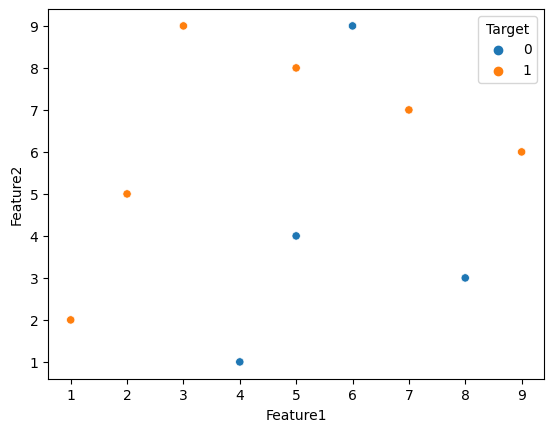

In [30]:
import seaborn as sns
sns.scatterplot(data=df, x="Feature1", y = "Feature2", hue="Target")

In [31]:
df.shape

(10, 3)

### Step#1: Weights Inialization

In [32]:
weights = 1/df.shape[0]
weights

0.1

In [33]:
df["Ini_Weights"] = weights
df

,Feature1,Feature2,Target,Ini_Weights
0,3,9,1,0.1
1,4,1,0,0.1
2,1,2,1,0.1
3,5,8,1,0.1
4,7,7,1,0.1
5,8,3,0,0.1
6,5,4,0,0.1
7,9,6,1,0.1
8,2,5,1,0.1
9,6,9,0,0.1


In [34]:
x = df.iloc[:,0:2].values
y = df.iloc[:,2].values

### Weak Learners using decision stumps

In [35]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
dt1 = DecisionTreeClassifier(max_depth=1)
dt1.fit(x,y)

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'x[1] <= 4.5\ngini = 0.48\nsamples = 10\nvalue = [4, 6]'),
 Text(0.25, 0.25, 'gini = 0.375\nsamples = 4\nvalue = [3, 1]'),
 Text(0.75, 0.25, 'gini = 0.278\nsamples = 6\nvalue = [1, 5]')]

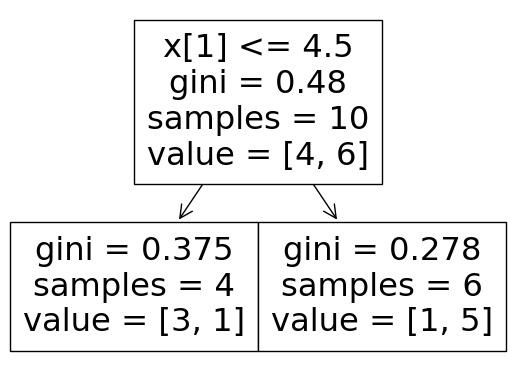

In [36]:
plot_tree(dt1)

### Seeing how much model is misclassified

<Axes: >

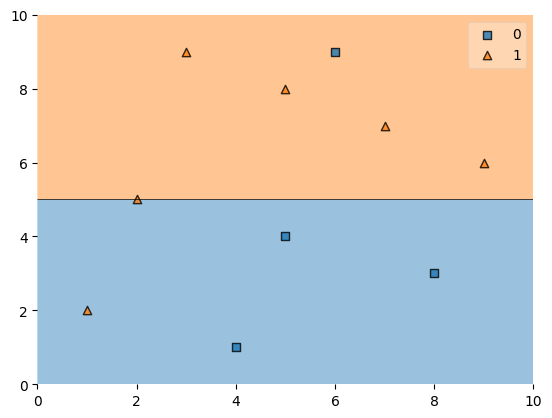

In [37]:
plot_decision_regions(x,y,clf=dt1)

### By watching the graph we examine that our model is doing 2 mistakes

In [39]:
Y_pred = dt1.predict(x)
df["y_pred"] = Y_pred

In [40]:
df

,Feature1,Feature2,Target,Ini_Weights,y_pred
0,3,9,1,0.1,1
1,4,1,0,0.1,0
2,1,2,1,0.1,0
3,5,8,1,0.1,1
4,7,7,1,0.1,1
5,8,3,0,0.1,0
6,5,4,0,0.1,0
7,9,6,1,0.1,1
8,2,5,1,0.1,1
9,6,9,0,0.1,1


### Step#2 Calculating weights using error

In [43]:
def calculate_model_weights(error):
    return 0.5*np.log((1-error)/(error))

In [44]:
alpha1 = calculate_model_weights(0.2)       ### As our model is doing mistakes on jsut 2 spots
alpha1

0.6931471805599453

### Step#3 Updating weights of the Model

In [51]:
def update_row_weights(row, alpha= alpha1):
    if row['Target'] == row['y_pred']:
        return weights*np.exp(-(alpha))
    else:
        return weights*np.exp(alpha)


In [53]:
df['updated_weights'] = df.apply(update_row_weights,axis=1)
df

,Feature1,Feature2,Target,Ini_Weights,y_pred,updated_weights
0,3,9,1,0.1,1,0.05
1,4,1,0,0.1,0,0.05
2,1,2,1,0.1,0,0.20
3,5,8,1,0.1,1,0.05
4,7,7,1,0.1,1,0.05
5,8,3,0,0.1,0,0.05
6,5,4,0,0.1,0,0.05
7,9,6,1,0.1,1,0.05
8,2,5,1,0.1,1,0.05
9,6,9,0,0.1,1,0.20


### So we observe that this is bossting in which the weights od those points increases where model is misclassified

In [55]:
df['updated_weights'].sum()     # we have to make the sum equla to 1

0.8

In [56]:
df['nomalized_weights'] = df['updated_weights']/df['updated_weights'].sum()

In [57]:
df['nomalized_weights'].sum()

1.0

### Step#4 range for upsampling

In [60]:
df['cumsum_upper'] = np.cumsum(df['nomalized_weights'])
df['cumsum_lower'] = df['cumsum_upper'] - df['nomalized_weights']

In [61]:
df

,Feature1,Feature2,Target,Ini_Weights,y_pred,updated_weights,nomalized_weights,cumsum_upper,cumsum_lower
0,3,9,1,0.1,1,0.05,0.0625,0.0625,0.0000
1,4,1,0,0.1,0,0.05,0.0625,0.1250,0.0625
2,1,2,1,0.1,0,0.20,0.2500,0.3750,0.1250
3,5,8,1,0.1,1,0.05,0.0625,0.4375,0.3750
4,7,7,1,0.1,1,0.05,0.0625,0.5000,0.4375
5,8,3,0,0.1,0,0.05,0.0625,0.5625,0.5000
6,5,4,0,0.1,0,0.05,0.0625,0.6250,0.5625
7,9,6,1,0.1,1,0.05,0.0625,0.6875,0.6250
8,2,5,1,0.1,1,0.05,0.0625,0.7500,0.6875
9,6,9,0,0.1,1,0.20,0.2500,1.0000,0.7500


### generating new dataset from the current on the basis of range having same number of rows

In [62]:
def create_new_dataset(df):

  indices = []

  for i in range(df.shape[0]):
    a = np.random.random()
    for index,row in df.iterrows():
      if row['cumsum_upper'] > a and a > row['cumsum_lower']:    ### now pick those rows where wrong prediction is done
        indices.append(index)
  return indices

In [63]:
index_values = create_new_dataset(df)
index_values

[6, 9, 8, 4, 2, 2, 9, 9, 7, 4]

In [65]:
second_df = df.iloc[index_values,[0,1,2,3]]
second_df

,Feature1,Feature2,Target,Ini_Weights
6,5,4,0,0.1
9,6,9,0,0.1
8,2,5,1,0.1
4,7,7,1,0.1
2,1,2,1,0.1
2,1,2,1,0.1
9,6,9,0,0.1
9,6,9,0,0.1
7,9,6,1,0.1
4,7,7,1,0.1


In [66]:
dt2 = DecisionTreeClassifier(max_depth=1)

In [67]:
X = second_df.iloc[:,0:2].values
y = second_df.iloc[:,2].values

In [68]:
dt2.fit(X,y)

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'x[1] <= 8.0\ngini = 0.48\nsamples = 10\nvalue = [4, 6]'),
 Text(0.25, 0.25, 'gini = 0.245\nsamples = 7\nvalue = [1, 6]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]')]

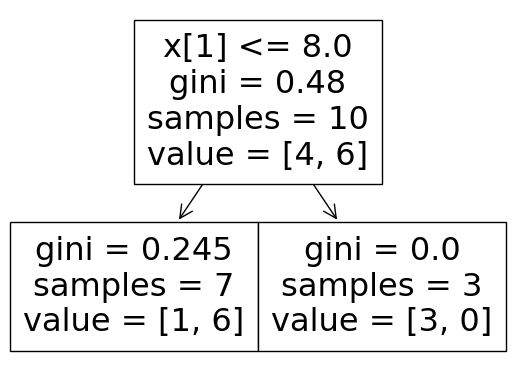

In [69]:
plot_tree(dt2)

<Axes: >

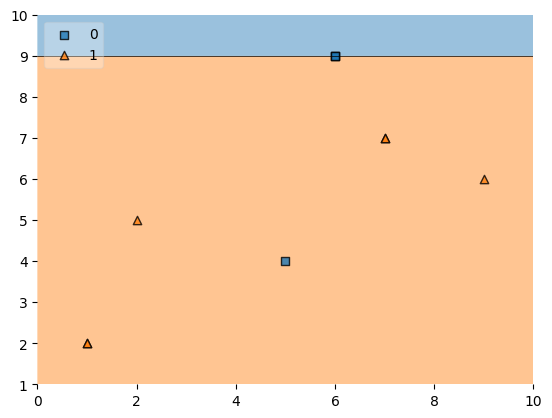

In [70]:
plot_decision_regions(X, y, clf=dt2, legend=2)

### Now our model is just trying to make correction in misclassified points 
but also one mistaj=ke and in next decion tree it will make it true by making it upsampled

In [71]:
second_df['y_pred'] = dt2.predict(X)
second_df

,Feature1,Feature2,Target,Ini_Weights,y_pred
6,5,4,0,0.1,1
9,6,9,0,0.1,0
8,2,5,1,0.1,1
4,7,7,1,0.1,1
2,1,2,1,0.1,1
2,1,2,1,0.1,1
9,6,9,0,0.1,0
9,6,9,0,0.1,0
7,9,6,1,0.1,1
4,7,7,1,0.1,1


In [73]:
alpha2 = calculate_model_weights(0.1)
alpha2

1.0986122886681098

In [78]:
def update_row_weights(row, alpha= alpha1):
    if row['Target'] == row['y_pred']:
        return weights*np.exp(-(alpha))
    else:
        return weights*np.exp(alpha)

In [79]:
second_df['updated_weights'] = second_df.apply(update_row_weights,axis=1)
second_df

,Feature1,Feature2,Target,Ini_Weights,y_pred,updated_weights
6,5,4,0,0.1,1,0.20
9,6,9,0,0.1,0,0.05
8,2,5,1,0.1,1,0.05
4,7,7,1,0.1,1,0.05
2,1,2,1,0.1,1,0.05
2,1,2,1,0.1,1,0.05
9,6,9,0,0.1,0,0.05
9,6,9,0,0.1,0,0.05
7,9,6,1,0.1,1,0.05
4,7,7,1,0.1,1,0.05


In [81]:
second_df['nomalized_weights'] = second_df['updated_weights']/second_df['updated_weights'].sum()
second_df['nomalized_weights'].sum()

0.9999999999999998

In [85]:
second_df['cumsum_upper'] = np.cumsum(second_df['nomalized_weights'])
second_df['cumsum_lower'] = second_df['cumsum_upper'] - second_df['nomalized_weights']
second_df

,Feature1,Feature2,Target,Ini_Weights,y_pred,updated_weights,nomalized_weights,cumsum_upper,cumsum_lower
6,5,4,0,0.1,1,0.20,0.307692,0.307692,0.000000
9,6,9,0,0.1,0,0.05,0.076923,0.384615,0.307692
8,2,5,1,0.1,1,0.05,0.076923,0.461538,0.384615
4,7,7,1,0.1,1,0.05,0.076923,0.538462,0.461538
2,1,2,1,0.1,1,0.05,0.076923,0.615385,0.538462
2,1,2,1,0.1,1,0.05,0.076923,0.692308,0.615385
9,6,9,0,0.1,0,0.05,0.076923,0.769231,0.692308
9,6,9,0,0.1,0,0.05,0.076923,0.846154,0.769231
7,9,6,1,0.1,1,0.05,0.076923,0.923077,0.846154
4,7,7,1,0.1,1,0.05,0.076923,1.000000,0.923077


### Predictio

In [90]:
query = np.array([5,4]).reshape(1,2)        # just taking the 1 data point
dt1.predict(query)

array([0], dtype=int64)

In [92]:
dt2.predict(query)

array([1], dtype=int64)

In [101]:
alpha1*(-1) + alpha2*(1)

0.4054651081081645

In [102]:
np.sign(0.405)       #showing it as labeled one

1.0

In [103]:
query = np.array([7,7]).reshape(1,2)        # just taking the last data point
dt1.predict(query)

array([1], dtype=int64)

In [98]:
dt1.predict(query)

array([1], dtype=int64)

In [99]:
dt2.predict(query)

array([1], dtype=int64)

In [100]:
alpha1*1 + alpha2*(1)

1.791759469228055

In [104]:
np.sign(1.79)

1.0